# Getting started with flows

**Goal:** This notebook shows some first steps using flows.

**Usage:** Try to understand the provided code.

**Dataset:** One dimnesional artifical data sets and the famous old faithfull data set. This dataset contains 272 waiting times between two eruptions of the old faithful Geyser in the Yellowstone national park.

**Content:** 
* Change of variables from $z \rightarrow z^2$ numerical solution
* Change of variables using `tfp.bijectors` 
* Chaining bijectors
* Learning of a simple bijector
* Bijector to fit the old faithfull dataset


In [1]:
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
    %tensorflow_version 2.x
except:
    IN_COLAB = False

In [2]:
import tensorflow as tf
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

Tensorflow version:  2.0.0  running in colab?:  False


In [3]:
if IN_COLAB:
    !pip install tensorflow_probability==0.8.0

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow_probability as tfp


%matplotlib inline
plt.style.use('default')

tfd = tfp.distributions
tfb = tfp.bijectors
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)
np.random.seed(42)
tf.random.set_seed(42)

TFP Version 0.8.0
TF  Version 2.0.0


In [5]:
plt.figure(figsize=(3,7))
plt.style.use('default') # macht den hintergrund weg 
plt.rcParams.update({'font.size': 15}) #Macht grosse axen

<Figure size 216x504 with 0 Axes>

# Training Bijectors

An extremly simple example, to go from a $N(0,1)$ Gaussian to a $N(5.0,0.2)$ Gaussian. 

#### Training Data
Let's sample some training data of our traget distribution:

## Fitting the old faithful

Finally we can start to deal with real world data such as the old-faithful geyser. 

(272, 1)

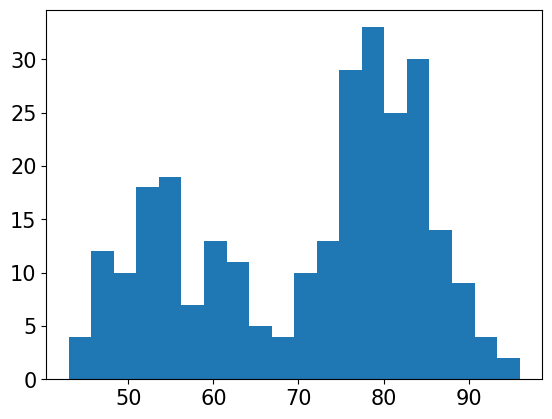

In [8]:
df1 = pd.read_csv('faithful.csv', delimiter=',')
X = np.asarray(df1.iloc[:,2],dtype='float32').reshape((-1,1))
plt.hist(X,20,col)
X.shape

## Non-Linearity

The SinhArcsinh Bijector has a complicated name but looks quite promising: it has two parameters skewness and tailweight and if tailweight>0 there are no restrictions on x and z. In the following we plot that Bijector for some parameters.

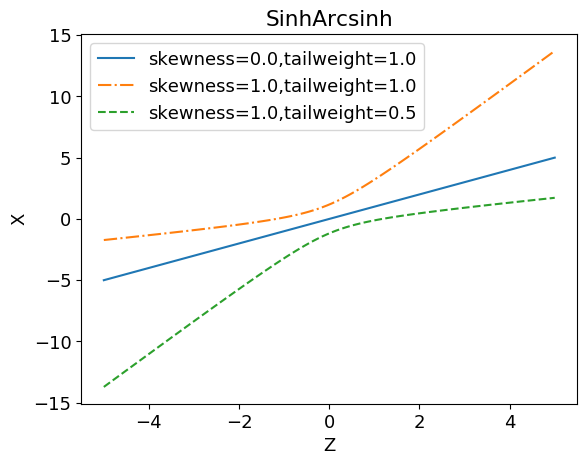

In [9]:
plt.rcParams.update({'font.size': 13}) #Macht grosse axen
zs = np.linspace(-5,5,100, dtype=np.float32)
plt.plot(zs, tfb.SinhArcsinh(skewness=0.0,tailweight=1.0).forward(zs))
plt.plot(zs, tfb.SinhArcsinh(skewness=1.0,tailweight=1.0).forward(zs),linestyle='-.')
plt.plot(zs, tfb.SinhArcsinh(skewness=-1.0,tailweight=1.0).forward(zs),linestyle='--')
plt.xlabel('Z')
plt.ylabel('X')
plt.title('SinhArcsinh')
plt.legend(['skewness=0.0,tailweight=1.0','skewness=1.0,tailweight=1.0','skewness=1.0,tailweight=0.5'])
plt.savefig('ch06_sin.pdf')

#### Listing 6.5: The simple example in TFP 

In [10]:
# 10          20       30        40       50         55
#123456789012345678901234567890123456789012345678901234

num_bijectors = 5 #A 
bs=[]
for i in range(num_bijectors):
    
    shift = tf.Variable(0.0)
    scale=tf.Variable(1.0)
    bs.append(tfb.AffineScalar(shift=shift, scale=scale))#B
    
    skewness=tf.Variable(0.0)
    tailweight=tf.Variable(1.0) 
    bs.append(tfb.SinhArcsinh(skewness,tailweight))#C
    

bijector = tfb.Chain(bs) #D
dist = tfd.TransformedDistribution(distribution=
        tfd.Normal(loc=0,scale=1),bijector=bijector)

#A Number of layers
#B The AffineScalar transformation
#C The SinhArcsinh acting as non-linearity
#D Creating the chain of bijectors from the list bijectors

In [11]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

@tf.function #Compiles function for fast execution
def train_step(X):
    with tf.GradientTape() as tape:
        loss = -tf.reduce_mean(dist.log_prob(X)) #C 
        gradients = tape.gradient(loss,dist.trainable_variables)     
        optimizer.apply_gradients(zip(gradients, dist.trainable_variables)) #E 
        return loss

for i in range(20000):
    loss = train_step(X)
    if (i % 2000 == 0 or i < 5):
        print(i, "NLL ",loss.numpy())

0 NLL  2606.1877
1 NLL  1541.5117
2 NLL  962.5718
3 NLL  635.1125
4 NLL  440.9034
2000 NLL  4.386953
4000 NLL  4.1083465
6000 NLL  4.0207634
8000 NLL  3.9419434
10000 NLL  3.8819408
12000 NLL  3.8407445
14000 NLL  3.8189259
16000 NLL  3.8069062
18000 NLL  3.800556


(array([ 4.,  9., 19., 51., 51., 54., 49., 20., 11.,  4.]),
 array([-2.8115110e+00, -2.2490933e+00, -1.6866758e+00, -1.1242580e+00,
        -5.6184042e-01,  5.7721138e-04,  5.6299484e-01,  1.1254125e+00,
         1.6878302e+00,  2.2502477e+00,  2.8126655e+00], dtype=float32),
 <a list of 10 Patch objects>)

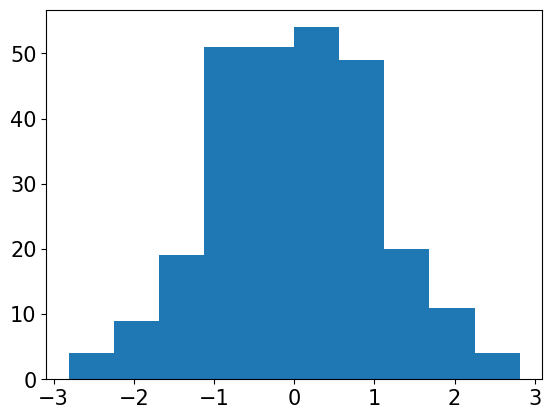

In [31]:
Z = bijector.inverse(X)[:,0]
plt.hist(Z)

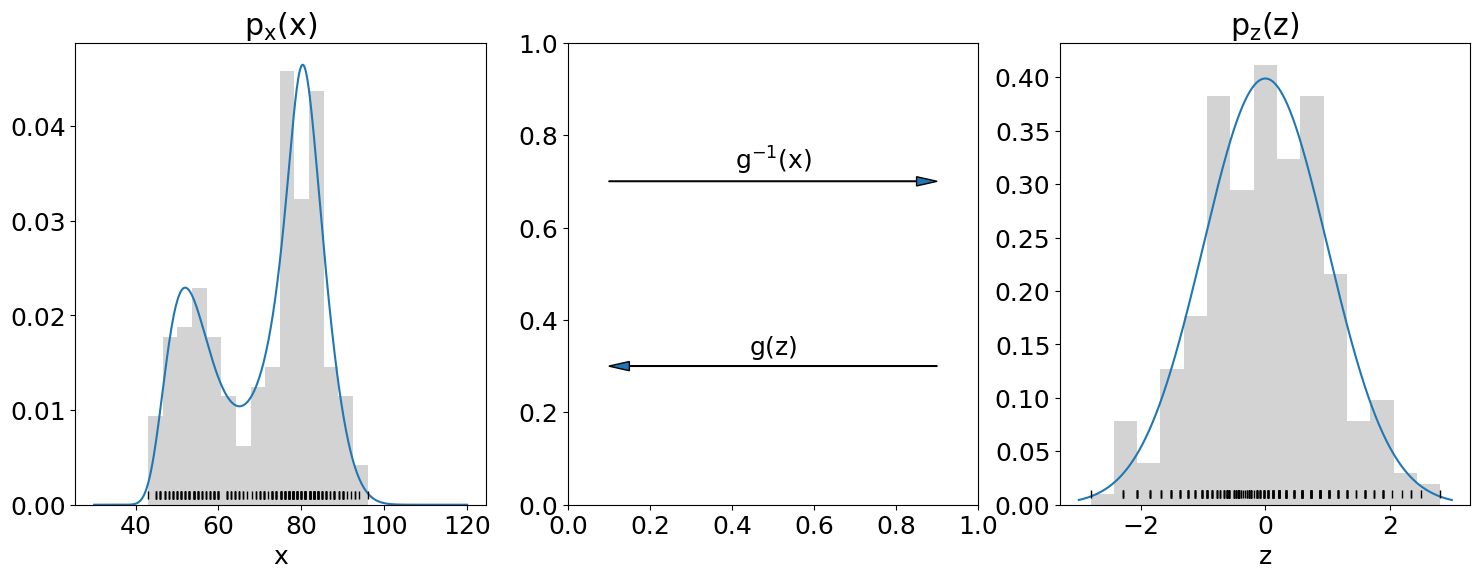

In [56]:
plt.rcParams.update({'font.size': 18}) #Macht grosse axen
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)

plt.hist(X, 15,density=True,color='lightgrey')
xs = np.linspace(30,120,500)
plt.plot(xs, dist.prob(xs))
plt.plot(X, [0.001]*len(X), '|', color='k')
plt.xlabel('x')
plt.title('$p_x(x)$')

plt.subplot(1,3,3)
Z = bijector.inverse(X)[:,0]


plt.hist(Z,15,density=True,color='lightgrey')
xs = np.linspace(-3,3,500)
plt.plot(xs, tfd.Normal(0,1).prob(xs))
plt.plot(Z, [0.01]*len(Z), '|', color='k')
plt.xlabel('z')
plt.title('$p_z(z)$')

plt.subplot(1,3,2)
plt.arrow(0.1, 0.7, 0.8, 0.0, length_includes_head=True, head_width=0.02, head_length=0.05)
plt.text(0.5,0.71,'$g^{-1}(x)$', horizontalalignment='center',verticalalignment='bottom')

plt.arrow(0.9, 0.3, -0.8, 0.0, length_includes_head=True, head_width=0.02, head_length=0.05)
plt.text(0.5,0.31,'$g(z)$', horizontalalignment='center',verticalalignment='bottom')



plt.savefig('ch06_nf.pdf')

#### Play around

<img src="https://raw.githubusercontent.com/tensorchiefs/dl_book/master/imgs/paper-pen.png" width="60" align="left" />  There is not formel excercise here. As usual play around and try to break it. For example use a smaller number of projectors.  

